In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time
import json
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

import cv2
import itertools
import random
from collections import Counter
from glob import iglob

In [2]:
#waktu awal proses eksekusi
start = time.time()

In [3]:
zip_file='Plant_leaf_diseases_dataset_without_augmentation.zip'

#definisikan file latih dan validasi
data_dir = os.path.join(os.path.dirname(zip_file), 'corn_dataset')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [4]:
#label mapping kelas yang ada
with open('corn_dataset/categories.json', 'r') as f:
    category_to_name = json.load(f)
    classes = list(category_to_name.values())
    
print (classes)

['Background_without_leaves', 'Corn____Cercospora_leaf_spot Gray_leaf_spot', 'Corn____Common_rust_', 'Corn____Northern_Leaf_Blight', 'Corn____healthy']


In [5]:
#rescale pixel, batch size
pixels = 72
image_size = (pixels, pixels)
batch_size = 128

In [6]:
#preprocessing data
#normalisasi dari `[0, 255]` range ke `[0, 1]` range
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=None, 
    color_mode="rgb", 
    class_mode="categorical", 
    target_size=image_size, 
    batch_size=batch_size)

do_data_augmentation = True

#normalisasi dan augmentasi data
if do_data_augmentation:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale = 1./255, 
        rotation_range=40, 
        horizontal_flip=True, 
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        shear_range=0.2, 
        zoom_range=0.2, 
        fill_mode='nearest' )
else:
    train_datagen = validation_datagen

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=None,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=image_size,
    batch_size=batch_size)

Found 998 images belonging to 5 classes.
Found 3997 images belonging to 5 classes.


In [7]:
#bangun model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(72, (3, 3), activation='relu', input_shape=(72, 72, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(input_shape=image_size+(3,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 70, 70, 72)        2016      
                                                                 
 max_pooling2d (MaxPooling2  (None, 35, 35, 72)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 33, 32)        20768     
                                                                 
 flatten (Flatten)           (None, 34848)             0         
                                                                 
 dense (Dense)               (None, 128)               4460672   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [9]:
#adam optimizer
learning_rate = 0.001
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [10]:
#latih model dengan 40 epochs
epochs = 50
epochs_steps = train_generator.samples//train_generator.batch_size
validation_steps = validation_generator.samples//validation_generator.batch_size

with tf.device('/device:GPU:0'):
    history = model.fit(
        train_generator, 
        steps_per_epoch=epochs_steps, 
        epochs=epochs, 
        validation_data=validation_generator, 
        validation_steps=validation_steps)

Epoch 1/50
31/31 [==============================] - 31s 956ms/step - loss: 1.3174 - accuracy: 0.4999 - val_loss: 0.5840 - val_accuracy: 0.8170
Epoch 2/50
31/31 [==============================] - 26s 829ms/step - loss: 0.5653 - accuracy: 0.7731 - val_loss: 0.5587 - val_accuracy: 0.8136
Epoch 3/50
31/31 [==============================] - 28s 886ms/step - loss: 0.4144 - accuracy: 0.8307 - val_loss: 0.3265 - val_accuracy: 0.8594
Epoch 4/50
31/31 [==============================] - 29s 911ms/step - loss: 0.3359 - accuracy: 0.8622 - val_loss: 0.2785 - val_accuracy: 0.8806
Epoch 5/50
31/31 [==============================] - 26s 828ms/step - loss: 0.3136 - accuracy: 0.8682 - val_loss: 0.3332 - val_accuracy: 0.8281
Epoch 6/50
31/31 [==============================] - 24s 755ms/step - loss: 0.3058 - accuracy: 0.8708 - val_loss: 0.3785 - val_accuracy: 0.8560
Epoch 7/50
31/31 [==============================] - 24s 758ms/step - loss: 0.2826 - accuracy: 0.8790 - val_loss: 0.2892 - val_accuracy: 0.8795

In [11]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


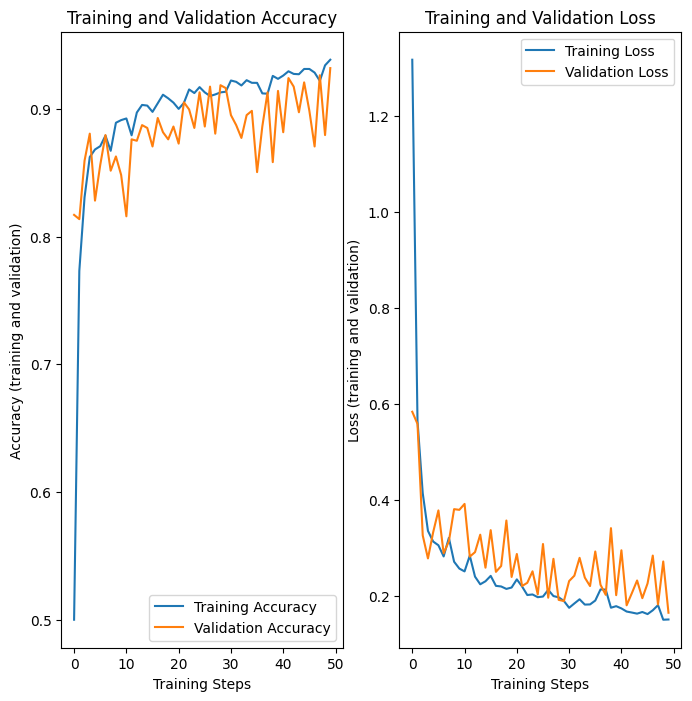

In [12]:
#plot accuracy dan loss pada data latih dan data validasi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")

plt.show()

In [13]:
#fungsi load image
def load_image(filename):
    img = cv2.imread(os.path.join(validation_dir, filename))
    img = cv2.resize(img, (image_size[0], image_size[1]) )
    img = img /255
    
    return img

#fungsi predict image dari model yang dibangun
def predict_image(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Corn___Northern_Leaf_Blight, file: Corn___Northern_Leaf_Blight\image (957).JPG
1/1 [==============================] - 0s 149ms/step
PREDICTED: class: Background_without_leaves, confidence: 0.573282


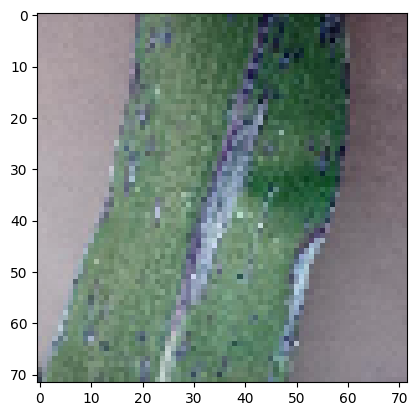

<Figure size 640x480 with 0 Axes>

SOURCE: class: Corn___healthy, file: Corn___healthy\image (1026).jpg
1/1 [==============================] - 0s 28ms/step
PREDICTED: class: Corn____healthy, confidence: 0.999999


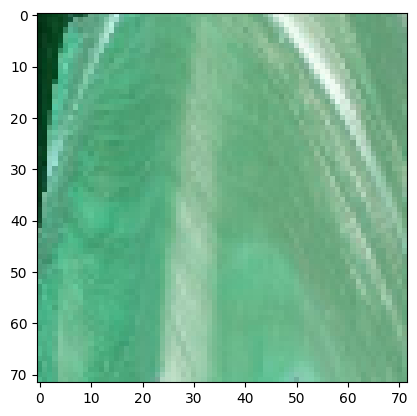

SOURCE: class: Corn___Northern_Leaf_Blight, file: Corn___Northern_Leaf_Blight\image (896).JPG
1/1 [==============================] - 0s 34ms/step
PREDICTED: class: Corn____Northern_Leaf_Blight, confidence: 0.779029


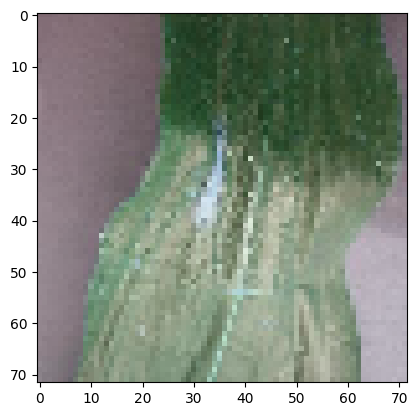

<Figure size 640x480 with 0 Axes>

SOURCE: class: Corn___Northern_Leaf_Blight, file: Corn___Northern_Leaf_Blight\image (885).JPG
1/1 [==============================] - 0s 25ms/step
PREDICTED: class: Corn____healthy, confidence: 0.927961


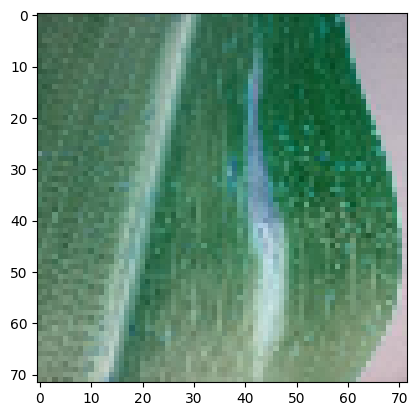

<Figure size 640x480 with 0 Axes>

SOURCE: class: Background_without_leaves, file: Background_without_leaves\image (1095).jpg
1/1 [==============================] - 0s 26ms/step
PREDICTED: class: Background_without_leaves, confidence: 0.999987


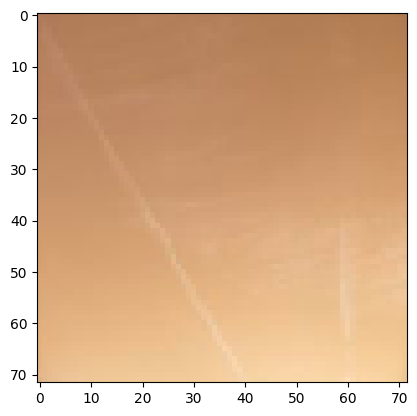

<Figure size 640x480 with 0 Axes>

SOURCE: class: Background_without_leaves, file: Background_without_leaves\image (1013).jpg
1/1 [==============================] - 0s 29ms/step
PREDICTED: class: Background_without_leaves, confidence: 1.000000


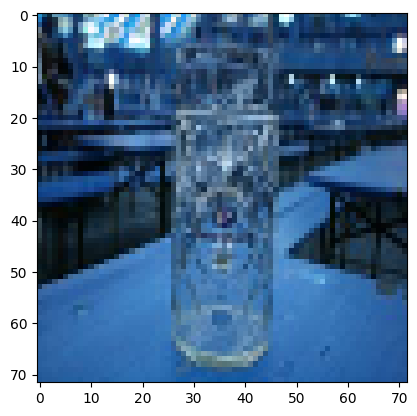

<Figure size 640x480 with 0 Axes>

SOURCE: class: Background_without_leaves, file: Background_without_leaves\image (1079).jpg
1/1 [==============================] - 0s 25ms/step
PREDICTED: class: Background_without_leaves, confidence: 1.000000


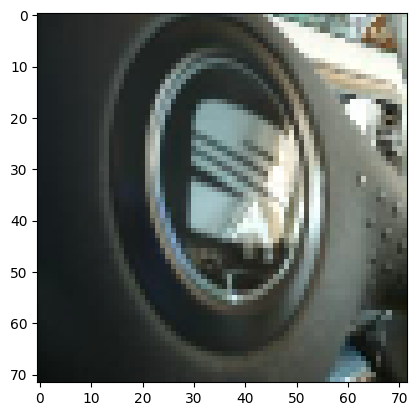

<Figure size 640x480 with 0 Axes>

SOURCE: class: Corn___healthy, file: Corn___healthy\image (968).jpg
1/1 [==============================] - 0s 29ms/step
PREDICTED: class: Corn____healthy, confidence: 0.999951


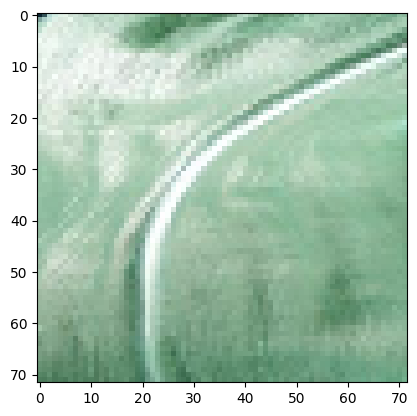

<Figure size 640x480 with 0 Axes>

SOURCE: class: Background_without_leaves, file: Background_without_leaves\image (939).jpg
1/1 [==============================] - 0s 29ms/step
PREDICTED: class: Background_without_leaves, confidence: 1.000000


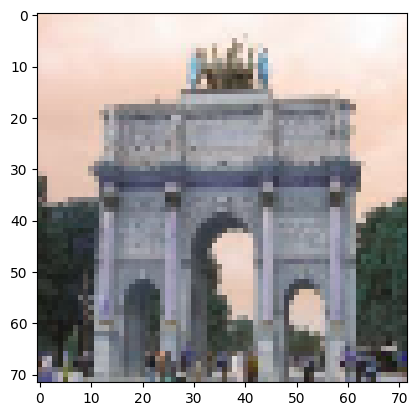

<Figure size 640x480 with 0 Axes>

SOURCE: class: Background_without_leaves, file: Background_without_leaves\image (1116).jpg
1/1 [==============================] - 0s 31ms/step
PREDICTED: class: Background_without_leaves, confidence: 0.999978


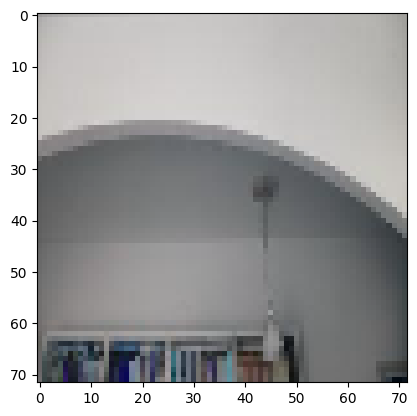

<Figure size 640x480 with 0 Axes>

In [14]:
#prediksi n-gambar secara random
n = 10
for idx, filename in enumerate(random.sample(validation_generator.filenames, n)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict_image(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()


In [15]:
# waktu akhir proses eksekusi
end = time.time()

In [16]:
#lama proses eksekusi
print("Lama eksekusi: ", end-start, "s")

Lama eksekusi:  1433.5881435871124 s


In [20]:
import os
model_version = max([int(i) for i in os.listdir("models") + [0]]) + 1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2\assets


INFO:tensorflow:Assets written to: models/2\assets
